In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import json
import datetime
import time

%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import descartes

import warnings
warnings.filterwarnings('ignore')

### Helper Functions

In [63]:
def checkinPreprocessing(checkins):
    #date and time processing

    #create date-time feature
    dateTime = checkins['datetime']
    dateTime.head()

    #split into date and time column 
    #year format: YYYY-MM-DD 
    #time format: HH:MM:SS

    hourOfCheckin = list()
    dayOfCheckin = list()
    weekdayOrWeekendCheckin = list()
    dateList = list()
    timeList = list()

    for index in range(0, dateTime.shape[0]):
        
        #convert date to date object
        date = dateTime[index][:dateTime[index].find("T")] #extract date from datetime string 
        year = int(date[:date.find("-")])
        month = int(date[date.find("-")+1:date.rfind("-")])
        day = int(date[date.rfind("-")+1:])
        date = datetime.date(year, month, day) #create a date object
        dateList.append(date)
        #convert time to time object
        time = dateTime[index][dateTime[index].find("T")+1:-1] #extract time as string 
        hour = int(time[:time.find(":")])
        minute = int(time[time.find(":")+1:time.rfind(":")])
        second = int(time[time.rfind(":")+1:])
        time = datetime.time(hour=hour, minute=minute, second=second)
        timeList.append(time)
        
        #from date object extract day of the week
        day = date.weekday() #integer representation of day of the week - 0 is Monday and 6 is Sunday
        dayOfCheckin.append(day)
        
        #hour of checkin - one hot encode this feature as 24 slots  
        hourOfCheckin.append(hour)
        
        #weekday or weekend - FEATURE
        if day == 5 or day == 6: #saturday or sunday 
            weekdayOrWeekendCheckin.append(1) #weekened checkin
        else:
            weekdayOrWeekendCheckin.append(0) #weekday checkin

    #add dates and times to the dataframe
    checkins['Date'] = dateList
    checkins['Time'] = timeList
    checkins['WeekdayOrWeekend'] = weekdayOrWeekendCheckin #add weekday or weekend field

    checkins.drop("datetime", axis=1, inplace=True)

    return checkins, dateList

def locationPreprocessing(placesDf):

    #extract the location information 
    locationInformation = list()
    for rowIndex in placesDf.index:
        
        rowInstance = placesDf['spot_categories'][rowIndex]
        firstIndex = rowInstance.rfind(":") + 3
        secondIndex = rowInstance.rfind("'")
        
        if len(locationInformation) == 0:
            locationInformation = [rowInstance[firstIndex:secondIndex].strip()]
        else:
            locationInformation.append(rowInstance[firstIndex:secondIndex].strip())
            
    #dataframe created for checking purposes
    placesDf['Locations'] = pd.DataFrame(locationInformation, columns=['Locations'])

    #use locationDf and the read in location category relationship df
    locationCategoryDf = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/LocationCategoryRelationshipsData.csv", usecols=['Specific Category', 'Main Category'])

    #connect the locationDf and the location category relationship df to align the POI categories with the locations
    placesDf = placesDf.join(locationCategoryDf.set_index('Specific Category'), on='Locations')

    #drop any unecessary columns
    placesDf.drop("created_at", axis=1, inplace=True)
    placesDf.drop("spot_categories", axis=1, inplace=True)

    placesDf.index = range(0, placesDf.shape[0]) #reindex so join is succesful
    
    return placesDf

### Main Code

In [64]:
#LOCATIONS
placesDf = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/gowalla/gowalla_spots_subset1.csv")
print("Locations Loaded")
placesDf = locationPreprocessing(placesDf)
print("Locations Processed")

Locations Loaded
Locations Processed


In [ ]:
chunksize = 10 ** 6
firstIteration = True
index = 0

for chunk in pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/gowalla/gowalla_checkins.csv", chunksize=chunksize):
    #each chunk is 1 million rows
    
    print("Start Iteration ", str(index))
    
    #checkin process chunk
    chunk.index = range(0,chunk.shape[0])
    checkins,dateList = checkinPreprocessing(chunk)
    
    #Join the locationDf and the checkinsDf
    checkins = checkins.join(placesDf.set_index('id'), on='placeid')
    
    #write out prior to aligning 
    if firstIteration:
        checkins.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/processedCheckins.csv", header=True, index=False)
        firstIteration = False
    else:
        checkins.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/processedCheckins.csv",  mode='a', header=False, index=False)
        
    print("Finished Iteration ", str(index))
    index += 1 
    

In [8]:
pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Data/gowalla/gowalla_checkins.csv").shape

(36001959, 3)

### Geospatial Mapping

In [ ]:
checkins = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/processedCheckins.csv")
#save geospatial mapping points
checkins[["lng", "lat"]].to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/checkinsGeospatialMarkers.csv")

In [42]:
#read in geospatial mapping file 
df = pd.read_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/checkinsGeospatialMarkers.csv")
df.columns = ['id', 'lng', 'lat'] #field rename
#read world shape file
worldMap = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

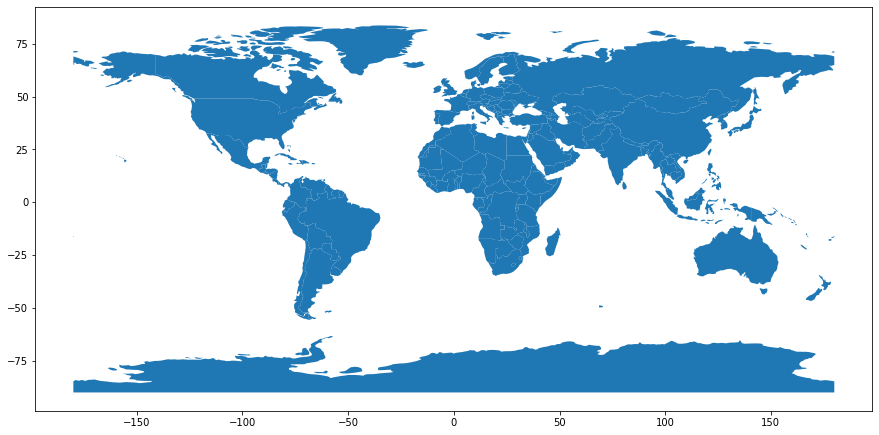

In [23]:
fig, ax = plt.subplots(figsize=(15,15))
worldMap.plot(ax=ax)
worldMap.

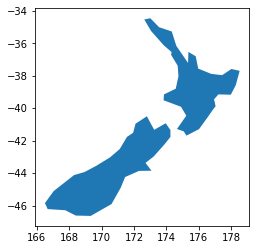

In [48]:
nzMap = worldMap[worldMap['name'] == "New Zealand"]
nzMap.plot()
#latitude = vertical
#longitude = horizontal

In [66]:
#subset to NZ checkins
lngMask = np.logical_and(df['lng'] > 166,df['lng'] < 180)
latMask = np.logical_and(df['lat'] > -48,df['lat'] < -34)
nzMask = np.logical_and(lngMask,latMask)
nzCheckins = df[nzMask]
nzCheckins.to_csv("/home/usermobilitymining/Notebooks/volume/Hasnain/Processed Data/nzCheckinsGeoSpatialInfo.csv", index=False)

In [63]:
geometry = [Point(xy) for xy in zip(nzCheckins['lng'], nzCheckins['lat'])]
crs = {'init': "+init=epsg:4326"} #co ordinate frame reference

In [64]:
#create a geo-dataframe
geoDf = gpd.GeoDataFrame(nzCheckins,
                        crs=crs, 
                        geometry=geometry)
geoDf.head()

,id,lng,lat,geometry
1511,1511,175.302670,-37.805193,POINT (175.30267 -37.80519)
25569,25569,174.783146,-37.005414,POINT (174.78315 -37.00541)
25570,25570,174.005198,-41.285401,POINT (174.00520 -41.28540)
25571,25571,170.966727,-42.719118,POINT (170.96673 -42.71912)
25572,25572,174.781725,-41.293435,POINT (174.78172 -41.29343)


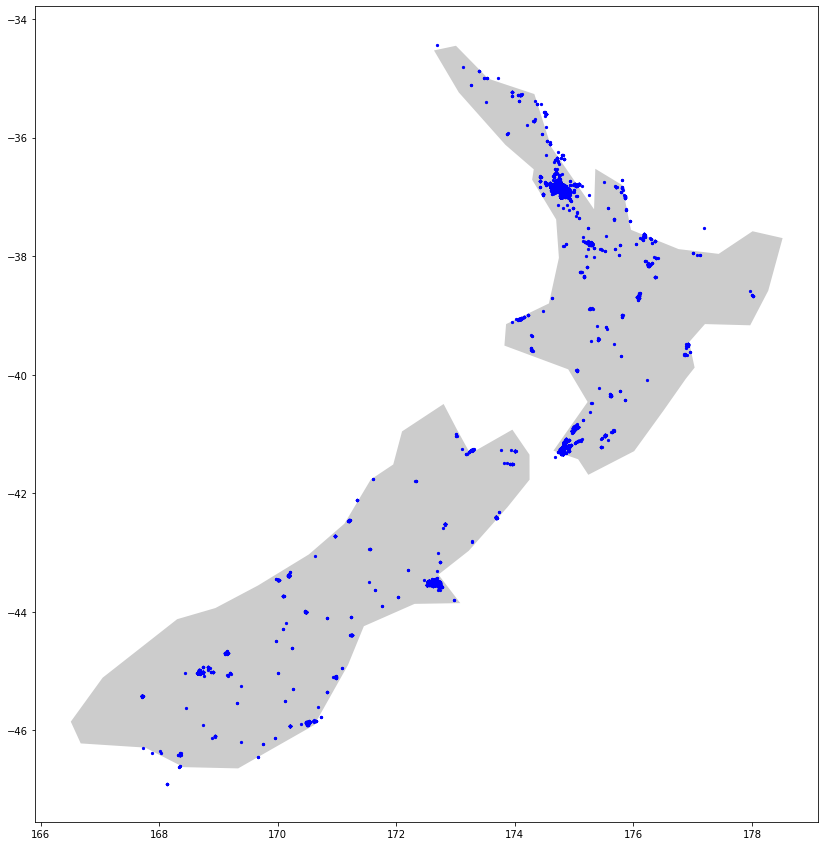

In [65]:
#plot checkins
fig, ax = plt.subplots(figsize=(15,15))
nzMap.plot(ax=ax,alpha=0.4,color="grey")
geoDf.plot(ax=ax, markersize=5, color="blue", marker="o")

In [ ]:
#divide into tokens (100m x 100m)

